<a href="https://colab.research.google.com/github/Mihirirj/Audio_PRE-FE/blob/main/CNN(CREMA_D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import pickle
from tqdm import tqdm
import timeit

In [2]:
# Audio Processing
import librosa
import librosa.display

In [3]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Scikit-learn for Preprocessing and Metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
# Keras / TensorFlow for Model Building
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [6]:
# Ignore warnings for a cleaner output
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
!apt-get update -qq && apt-get install -y libsndfile1 -qq

print("Libraries imported and system updated successfully.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Libraries imported and system updated successfully.


In [8]:
print("\nStep 2: Mounting Google Drive and setting paths...")

from google.colab import drive
drive.mount('/content/drive')


Step 2: Mounting Google Drive and setting paths...
Mounted at /content/drive


In [9]:
CREMA_D_PATH = "/content/drive/MyDrive/AudioWAV/"

if not os.path.exists(CREMA_D_PATH):
    print(f"ERROR: The path '{CREMA_D_PATH}' does not exist.")
    print("Please make sure you have uploaded the 'AudioWAV' folder to your Google Drive and updated the CREMA_D_PATH variable.")
else:
    print("Dataset path confirmed.")

Dataset path confirmed.


In [10]:
# STEP 3: LOAD AND PROCESS DATASET METADATA
# ==============================================================================
print("\nStep 3: Loading and processing CREMA-D metadata...")

crema_directory_list = os.listdir(CREMA_D_PATH)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(os.path.join(CREMA_D_PATH, file))
    # storing file emotions
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# DataFrame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# DataFrame for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
data_path = pd.concat([emotion_df, path_df], axis=1)

print("CREMA-D DataFrame created successfully.")
print("Emotion Counts:")
print(data_path['Emotions'].value_counts())
print("\nDataFrame Head:")
print(data_path.head())


Step 3: Loading and processing CREMA-D metadata...
CREMA-D DataFrame created successfully.
Emotion Counts:
Emotions
sad        1271
happy      1271
angry      1271
fear       1271
disgust    1271
neutral    1087
Name: count, dtype: int64

DataFrame Head:
  Emotions                                               Path
0      sad  /content/drive/MyDrive/AudioWAV/1080_DFA_SAD_X...
1    happy  /content/drive/MyDrive/AudioWAV/1079_WSI_HAP_X...
2    angry  /content/drive/MyDrive/AudioWAV/1079_TSI_ANG_X...
3  neutral  /content/drive/MyDrive/AudioWAV/1080_DFA_NEU_X...
4     fear  /content/drive/MyDrive/AudioWAV/1079_WSI_FEA_X...



Step 4: Visualizing data distribution...


/tmp/ipython-input-11-3406805176.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_path.Emotions, palette="viridis")


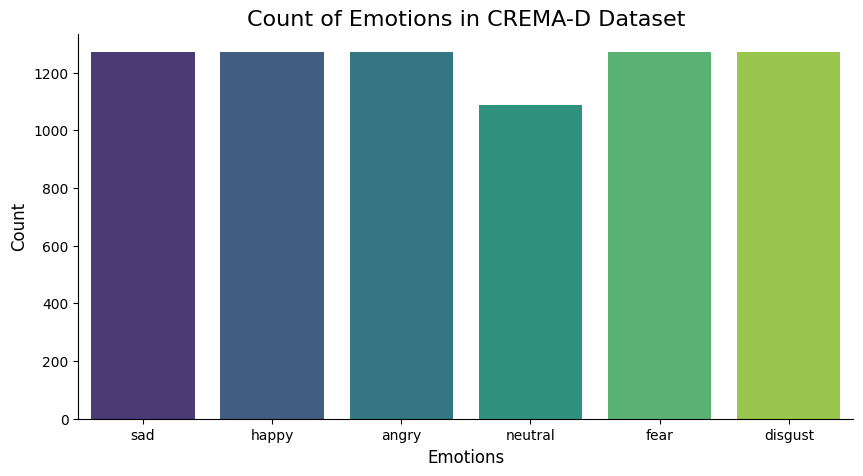

In [11]:
print("\nStep 4: Visualizing data distribution...")

plt.figure(figsize=(10, 5))
plt.title('Count of Emotions in CREMA-D Dataset', size=16)
sns.countplot(x=data_path.Emotions, palette="viridis")
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [12]:
# ==============================================================================
# STEP 5: FEATURE EXTRACTION & AUGMENTATION FUNCTIONS
# ==============================================================================
print("\nStep 5: Defining feature extraction and augmentation functions...")

# --- Data Augmentation Functions ---
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# --- Feature Extraction Functions ---
def extract_features(data, sr=22050):
    result = np.array([])
    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))
    # RMS
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc))
    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mel))

    return result

def get_features_with_augmentation(path):
    # Load audio file
    data, sr = librosa.load(path, duration=2.5, offset=0.6)

    # Original audio features
    res1 = extract_features(data, sr)

    # Noise augmented audio features
    noise_data = noise(data)
    res2 = extract_features(noise_data, sr)

    # Pitch augmented audio features
    pitch_data = pitch(data, sr)
    res3 = extract_features(pitch_data, sr)

    # Combine all features
    all_features = np.vstack((res1, res2, res3))

    return all_features

print("Functions defined.")


Step 5: Defining feature extraction and augmentation functions...
Functions defined.


In [14]:
# ==============================================================================
# STEP 6: GENERATE AND SAVE FEATURES (LONG PROCESS)
# ==============================================================================
print("\nStep 6: Generating features from audio files. This may take a long time...")

start_time = timeit.default_timer()

X, Y = [], []
for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions), total=len(data_path)):
    try:
        features = get_features_with_augmentation(path)
        for f in features:
            X.append(f)
            Y.append(emotion)
    except Exception as e:
        print(f"Error processing {path}: {e}")

stop_time = timeit.default_timer()
print(f'\nFeature extraction completed in: {stop_time - start_time:.2f}s')

# Save features to avoid re-running this step
features_df = pd.DataFrame(X)
features_df['Emotions'] = Y
features_df.to_csv('crema_features_with_augmentation.csv', index=False)
print("Features saved to 'crema_features_with_augmentation.csv'")


Step 6: Generating features from audio files. This may take a long time...


100%|██████████| 7442/7442 [1:18:12<00:00,  1.59it/s]



Feature extraction completed in: 4692.62s
Features saved to 'crema_features_with_augmentation.csv'


In [15]:
# STEP 7: LOAD SAVED FEATURES AND PREPARE FOR MODELING
# ==============================================================================
print("\nStep 7: Loading features and preparing data for the model...")

# Load the saved features
features_df = pd.read_csv('crema_features_with_augmentation.csv')
print(f"Loaded {len(features_df)} feature sets.")

# Separate features (X) and labels (Y)
X = features_df.drop('Emotions', axis=1).values
Y = features_df['Emotions'].values

# One-Hot Encode the labels
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)

# Scale the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape data for the 1D CNN model
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

print(f"Data shapes: \nx_train: {x_train.shape}\ny_train: {y_train.shape}\nx_test: {x_test.shape}\ny_test: {y_test.shape}")



Step 7: Loading features and preparing data for the model...
Loaded 22326 feature sets.
Data shapes: 
x_train: (17860, 143, 1)
y_train: (17860, 6)
x_test: (4466, 143, 1)
y_test: (4466, 6)


In [16]:
# STEP 8: BUILD THE 1D CONVOLUTIONAL NEURAL NETWORK (CNN)
# ==============================================================================
print("\nStep 8: Building the 1D CNN model...")

model = Sequential([
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),

    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),

    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),

    Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Step 8: Building the 1D CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 143, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 143, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 72, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 72, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 36, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 36, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 18, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,038 (2.27 MB)

 Trainable params: 594,374 (2.27 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [17]:
print("\nStep 9: Training the model...")

# Define callbacks
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,  # Increased epochs, EarlyStopping will handle stopping
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, lr_reduction, model_checkpoint]
)


Step 9: Training the model...
Epoch 1/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.3375 - loss: 1.6509

280/280 ━━━━━━━━━━━━━━━━━━━━ 123s 421ms/step - accuracy: 0.3377 - loss: 1.6501 - val_accuracy: 0.2244 - val_loss: 1.6676 - learning_rate: 0.0010
Epoch 2/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.3959 - loss: 1.4567

280/280 ━━━━━━━━━━━━━━━━━━━━ 142s 423ms/step - accuracy: 0.3960 - loss: 1.4564 - val_accuracy: 0.2703 - val_loss: 1.6041 - learning_rate: 0.0010
Epoch 3/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.4313 - loss: 1.4015

280/280 ━━━━━━━━━━━━━━━━━━━━ 123s 439ms/step - accuracy: 0.4313 - loss: 1.4015 - val_accuracy: 0.3034 - val_loss: 1.7830 - learning_rate: 0.0010
Epoch 4/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.4471 - loss: 1.3697

280/280 ━━━━━━━━━━━━━━━━━━━━ 136s 416ms/step - accuracy: 0.4471 - loss: 1.3697 - val_accuracy: 0.4194 - val_loss: 1.4393 - learning_rate: 0.0010
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 146s 431ms/step - accuracy: 0.4590 - loss: 1.3442 - val_accuracy: 0.3777 - val_loss: 1.5614 - learning_rate: 0.0010
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 138s 418ms/step - accuracy: 0.4636 - loss: 1.3339 - val_accuracy: 0.3912 - val_loss: 1.6068 - learning_rate: 0.0010
Epoch 7/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.4738 - loss: 1.3141

280/280 ━━━━━━━━━━━━━━━━━━━━ 144s 426ms/step - accuracy: 0.4738 - loss: 1.3141 - val_accuracy: 0.4425 - val_loss: 1.3809 - learning_rate: 0.0010
Epoch 8/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.4750 - loss: 1.3068

280/280 ━━━━━━━━━━━━━━━━━━━━ 144s 433ms/step - accuracy: 0.4750 - loss: 1.3068 - val_accuracy: 0.4615 - val_loss: 1.3423 - learning_rate: 0.0010
Epoch 9/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 137s 417ms/step - accuracy: 0.4825 - loss: 1.2910 - val_accuracy: 0.4165 - val_loss: 1.4098 - learning_rate: 0.0010
Epoch 10/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 119s 424ms/step - accuracy: 0.4967 - loss: 1.2689 - val_accuracy: 0.4149 - val_loss: 1.5244 - learning_rate: 0.0010
Epoch 11/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 128s 457ms/step - accuracy: 0.5065 - loss: 1.2390 - val_accuracy: 0.3997 - val_loss: 1.4771 - learning_rate: 0.0010
Epoch 12/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 133s 423ms/step - accuracy: 0.5029 - loss: 1.2424 - val_accuracy: 0.3126 - val_loss: 1.6048 - learning_rate: 0.0010
Epoch 13/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.5048 - loss: 1.2385
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
280/280 ━━━━━━━━━━━━━━━━━━━━ 116s 415ms/step - accuracy: 

280/280 ━━━━━━━━━━━━━━━━━━━━ 117s 417ms/step - accuracy: 0.5272 - loss: 1.1896 - val_accuracy: 0.4691 - val_loss: 1.3157 - learning_rate: 5.0000e-04
Epoch 15/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 142s 417ms/step - accuracy: 0.5517 - loss: 1.1441 - val_accuracy: 0.4073 - val_loss: 1.4952 - learning_rate: 5.0000e-04
Epoch 16/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.5553 - loss: 1.1269

280/280 ━━━━━━━━━━━━━━━━━━━━ 143s 422ms/step - accuracy: 0.5553 - loss: 1.1270 - val_accuracy: 0.4933 - val_loss: 1.3015 - learning_rate: 5.0000e-04
Epoch 17/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.5617 - loss: 1.1100

280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 418ms/step - accuracy: 0.5617 - loss: 1.1101 - val_accuracy: 0.4962 - val_loss: 1.2801 - learning_rate: 5.0000e-04
Epoch 18/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 121s 432ms/step - accuracy: 0.5735 - loss: 1.0860 - val_accuracy: 0.4198 - val_loss: 1.4273 - learning_rate: 5.0000e-04
Epoch 19/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.5789 - loss: 1.0750

280/280 ━━━━━━━━━━━━━━━━━━━━ 136s 412ms/step - accuracy: 0.5788 - loss: 1.0750 - val_accuracy: 0.4978 - val_loss: 1.2594 - learning_rate: 5.0000e-04
Epoch 20/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5829 - loss: 1.0669

280/280 ━━━━━━━━━━━━━━━━━━━━ 147s 429ms/step - accuracy: 0.5829 - loss: 1.0669 - val_accuracy: 0.5325 - val_loss: 1.2071 - learning_rate: 5.0000e-04
Epoch 21/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.5995 - loss: 1.0316

280/280 ━━━━━━━━━━━━━━━━━━━━ 138s 414ms/step - accuracy: 0.5994 - loss: 1.0316 - val_accuracy: 0.5412 - val_loss: 1.1730 - learning_rate: 5.0000e-04
Epoch 22/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 142s 415ms/step - accuracy: 0.6033 - loss: 1.0071 - val_accuracy: 0.5298 - val_loss: 1.2329 - learning_rate: 5.0000e-04
Epoch 23/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 116s 415ms/step - accuracy: 0.6103 - loss: 0.9944 - val_accuracy: 0.4913 - val_loss: 1.2852 - learning_rate: 5.0000e-04
Epoch 24/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 116s 414ms/step - accuracy: 0.6221 - loss: 0.9778 - val_accuracy: 0.4760 - val_loss: 1.3937 - learning_rate: 5.0000e-04
Epoch 25/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.6294 - loss: 0.9486

280/280 ━━━━━━━━━━━━━━━━━━━━ 143s 416ms/step - accuracy: 0.6294 - loss: 0.9486 - val_accuracy: 0.5479 - val_loss: 1.1958 - learning_rate: 5.0000e-04
Epoch 26/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 121s 431ms/step - accuracy: 0.6401 - loss: 0.9300 - val_accuracy: 0.5450 - val_loss: 1.1646 - learning_rate: 5.0000e-04
Epoch 27/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 115s 410ms/step - accuracy: 0.6397 - loss: 0.9339 - val_accuracy: 0.4678 - val_loss: 1.4106 - learning_rate: 5.0000e-04
Epoch 28/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.6339 - loss: 0.9461

280/280 ━━━━━━━━━━━━━━━━━━━━ 115s 412ms/step - accuracy: 0.6339 - loss: 0.9461 - val_accuracy: 0.5488 - val_loss: 1.1755 - learning_rate: 5.0000e-04
Epoch 29/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 118s 421ms/step - accuracy: 0.6535 - loss: 0.9015 - val_accuracy: 0.5271 - val_loss: 1.2354 - learning_rate: 5.0000e-04
Epoch 30/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 117s 416ms/step - accuracy: 0.6106 - loss: 0.9968 - val_accuracy: 0.5439 - val_loss: 1.1771 - learning_rate: 5.0000e-04
Epoch 31/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 117s 419ms/step - accuracy: 0.6517 - loss: 0.8969 - val_accuracy: 0.4962 - val_loss: 1.3880 - learning_rate: 5.0000e-04
Epoch 32/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 140s 413ms/step - accuracy: 0.6639 - loss: 0.8590 - val_accuracy: 0.5410 - val_loss: 1.3093 - learning_rate: 5.0000e-04
Epoch 33/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.6584 - loss: 0.8801

280/280 ━━━━━━━━━━━━━━━━━━━━ 143s 415ms/step - accuracy: 0.6585 - loss: 0.8800 - val_accuracy: 0.5578 - val_loss: 1.2086 - learning_rate: 5.0000e-04
Epoch 34/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6851 - loss: 0.8180

280/280 ━━━━━━━━━━━━━━━━━━━━ 147s 433ms/step - accuracy: 0.6851 - loss: 0.8180 - val_accuracy: 0.5638 - val_loss: 1.2404 - learning_rate: 5.0000e-04
Epoch 35/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6561 - loss: 0.8848

280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 429ms/step - accuracy: 0.6561 - loss: 0.8847 - val_accuracy: 0.5696 - val_loss: 1.1226 - learning_rate: 5.0000e-04
Epoch 36/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.6785 - loss: 0.8230

280/280 ━━━━━━━━━━━━━━━━━━━━ 118s 421ms/step - accuracy: 0.6785 - loss: 0.8230 - val_accuracy: 0.5916 - val_loss: 1.1083 - learning_rate: 5.0000e-04
Epoch 37/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 416ms/step - accuracy: 0.6912 - loss: 0.7991 - val_accuracy: 0.4971 - val_loss: 1.3922 - learning_rate: 5.0000e-04
Epoch 38/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 142s 418ms/step - accuracy: 0.6570 - loss: 0.8880 - val_accuracy: 0.5658 - val_loss: 1.1570 - learning_rate: 5.0000e-04
Epoch 39/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 148s 439ms/step - accuracy: 0.7036 - loss: 0.7723 - val_accuracy: 0.5607 - val_loss: 1.1977 - learning_rate: 5.0000e-04
Epoch 40/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 122s 436ms/step - accuracy: 0.7046 - loss: 0.7667 - val_accuracy: 0.5540 - val_loss: 1.1947 - learning_rate: 5.0000e-04
Epoch 41/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.6830 - loss: 0.8157
Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
280/280 ━━━━━━━━━━━━━━━━━━━━ 139s 42

280/280 ━━━━━━━━━━━━━━━━━━━━ 121s 433ms/step - accuracy: 0.7180 - loss: 0.7448 - val_accuracy: 0.6050 - val_loss: 1.0856 - learning_rate: 2.5000e-04
Epoch 43/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.7196 - loss: 0.7301

280/280 ━━━━━━━━━━━━━━━━━━━━ 139s 423ms/step - accuracy: 0.7196 - loss: 0.7300 - val_accuracy: 0.6070 - val_loss: 1.0774 - learning_rate: 2.5000e-04
Epoch 44/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7455 - loss: 0.6764

280/280 ━━━━━━━━━━━━━━━━━━━━ 124s 444ms/step - accuracy: 0.7455 - loss: 0.6764 - val_accuracy: 0.6099 - val_loss: 1.0625 - learning_rate: 2.5000e-04
Epoch 45/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 136s 424ms/step - accuracy: 0.7518 - loss: 0.6514 - val_accuracy: 0.5734 - val_loss: 1.1773 - learning_rate: 2.5000e-04
Epoch 46/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 144s 431ms/step - accuracy: 0.7463 - loss: 0.6620 - val_accuracy: 0.6012 - val_loss: 1.1060 - learning_rate: 2.5000e-04
Epoch 47/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 429ms/step - accuracy: 0.7557 - loss: 0.6375 - val_accuracy: 0.6003 - val_loss: 1.1038 - learning_rate: 2.5000e-04
Epoch 48/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.7611 - loss: 0.6320

280/280 ━━━━━━━━━━━━━━━━━━━━ 119s 423ms/step - accuracy: 0.7611 - loss: 0.6321 - val_accuracy: 0.6108 - val_loss: 1.0932 - learning_rate: 2.5000e-04
Epoch 49/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 140s 417ms/step - accuracy: 0.7600 - loss: 0.6235 - val_accuracy: 0.6095 - val_loss: 1.0810 - learning_rate: 2.5000e-04
Epoch 50/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 142s 416ms/step - accuracy: 0.7707 - loss: 0.6048 - val_accuracy: 0.5860 - val_loss: 1.1540 - learning_rate: 2.5000e-04
Epoch 51/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 121s 431ms/step - accuracy: 0.7770 - loss: 0.5937 - val_accuracy: 0.5681 - val_loss: 1.2129 - learning_rate: 2.5000e-04
Epoch 52/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 138s 416ms/step - accuracy: 0.7735 - loss: 0.5990 - val_accuracy: 0.5927 - val_loss: 1.2336 - learning_rate: 2.5000e-04
Epoch 53/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7761 - loss: 0.5855
Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
280/280 ━━━━━━━━━━━━━━━━━━━━ 143s 42

280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 418ms/step - accuracy: 0.7880 - loss: 0.5609 - val_accuracy: 0.6111 - val_loss: 1.0779 - learning_rate: 1.2500e-04
Epoch 55/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7994 - loss: 0.5370

280/280 ━━━━━━━━━━━━━━━━━━━━ 122s 435ms/step - accuracy: 0.7994 - loss: 0.5370 - val_accuracy: 0.6140 - val_loss: 1.1295 - learning_rate: 1.2500e-04
Epoch 56/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7969 - loss: 0.5300

280/280 ━━━━━━━━━━━━━━━━━━━━ 144s 441ms/step - accuracy: 0.7969 - loss: 0.5301 - val_accuracy: 0.6146 - val_loss: 1.1236 - learning_rate: 1.2500e-04
Epoch 57/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8019 - loss: 0.5327

280/280 ━━━━━━━━━━━━━━━━━━━━ 137s 423ms/step - accuracy: 0.8019 - loss: 0.5327 - val_accuracy: 0.6207 - val_loss: 1.0989 - learning_rate: 1.2500e-04
Epoch 58/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 142s 424ms/step - accuracy: 0.8038 - loss: 0.5158 - val_accuracy: 0.6086 - val_loss: 1.1734 - learning_rate: 1.2500e-04
Epoch 59/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 419ms/step - accuracy: 0.8054 - loss: 0.5201 - val_accuracy: 0.6124 - val_loss: 1.1968 - learning_rate: 1.2500e-04
Epoch 60/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8031 - loss: 0.5186

280/280 ━━━━━━━━━━━━━━━━━━━━ 145s 429ms/step - accuracy: 0.8031 - loss: 0.5186 - val_accuracy: 0.6225 - val_loss: 1.1154 - learning_rate: 1.2500e-04
Epoch 61/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 137s 412ms/step - accuracy: 0.8070 - loss: 0.5021 - val_accuracy: 0.6214 - val_loss: 1.1139 - learning_rate: 1.2500e-04
Epoch 62/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 143s 415ms/step - accuracy: 0.8066 - loss: 0.5013 - val_accuracy: 0.6191 - val_loss: 1.1185 - learning_rate: 1.2500e-04
Epoch 63/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 120s 429ms/step - accuracy: 0.8048 - loss: 0.5099 - val_accuracy: 0.6104 - val_loss: 1.1221 - learning_rate: 1.2500e-04
Epoch 64/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 139s 417ms/step - accuracy: 0.8045 - loss: 0.5050 - val_accuracy: 0.6191 - val_loss: 1.1080 - learning_rate: 1.2500e-04
Epoch 65/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8128 - loss: 0.4911

280/280 ━━━━━━━━━━━━━━━━━━━━ 140s 411ms/step - accuracy: 0.8128 - loss: 0.4912 - val_accuracy: 0.6232 - val_loss: 1.1103 - learning_rate: 1.2500e-04
Epoch 66/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 116s 415ms/step - accuracy: 0.8219 - loss: 0.4694 - val_accuracy: 0.6189 - val_loss: 1.1111 - learning_rate: 1.2500e-04
Epoch 67/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 117s 417ms/step - accuracy: 0.8117 - loss: 0.4933 - val_accuracy: 0.6153 - val_loss: 1.1869 - learning_rate: 1.2500e-04
Epoch 68/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 147s 433ms/step - accuracy: 0.8058 - loss: 0.5082 - val_accuracy: 0.6068 - val_loss: 1.1367 - learning_rate: 1.2500e-04
Epoch 69/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 139s 423ms/step - accuracy: 0.8015 - loss: 0.5158 - val_accuracy: 0.6146 - val_loss: 1.1569 - learning_rate: 1.2500e-04
Epoch 70/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.7913 - loss: 0.5328
Epoch 70: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
280/280 ━━━━━━━━━━━━━━━━━━━━ 145s 435

280/280 ━━━━━━━━━━━━━━━━━━━━ 116s 414ms/step - accuracy: 0.8262 - loss: 0.4515 - val_accuracy: 0.6281 - val_loss: 1.1105 - learning_rate: 6.2500e-05
Epoch 73/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 142s 416ms/step - accuracy: 0.8223 - loss: 0.4664 - val_accuracy: 0.6167 - val_loss: 1.1442 - learning_rate: 6.2500e-05
Epoch 74/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 119s 424ms/step - accuracy: 0.8365 - loss: 0.4471 - val_accuracy: 0.6200 - val_loss: 1.1205 - learning_rate: 6.2500e-05
Epoch 75/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 140s 418ms/step - accuracy: 0.8337 - loss: 0.4422 - val_accuracy: 0.6272 - val_loss: 1.1328 - learning_rate: 6.2500e-05
Epoch 76/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 414ms/step - accuracy: 0.8315 - loss: 0.4487 - val_accuracy: 0.6234 - val_loss: 1.1137 - learning_rate: 6.2500e-05
Epoch 77/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8357 - loss: 0.4335
Epoch 77: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
280/280 ━━━━━━━━━━━━━━━━━━━━ 147s 43

280/280 ━━━━━━━━━━━━━━━━━━━━ 118s 422ms/step - accuracy: 0.8407 - loss: 0.4276 - val_accuracy: 0.6292 - val_loss: 1.1263 - learning_rate: 3.1250e-05
Epoch 79/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8378 - loss: 0.4308

280/280 ━━━━━━━━━━━━━━━━━━━━ 140s 415ms/step - accuracy: 0.8378 - loss: 0.4308 - val_accuracy: 0.6303 - val_loss: 1.1305 - learning_rate: 3.1250e-05
Epoch 80/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 116s 415ms/step - accuracy: 0.8390 - loss: 0.4325 - val_accuracy: 0.6261 - val_loss: 1.1441 - learning_rate: 3.1250e-05
Epoch 81/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8379 - loss: 0.4252

280/280 ━━━━━━━━━━━━━━━━━━━━ 144s 422ms/step - accuracy: 0.8380 - loss: 0.4252 - val_accuracy: 0.6314 - val_loss: 1.1312 - learning_rate: 3.1250e-05
Epoch 82/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 140s 415ms/step - accuracy: 0.8377 - loss: 0.4255 - val_accuracy: 0.6267 - val_loss: 1.1446 - learning_rate: 3.1250e-05
Epoch 83/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 146s 431ms/step - accuracy: 0.8440 - loss: 0.4235 - val_accuracy: 0.6283 - val_loss: 1.1361 - learning_rate: 3.1250e-05
Epoch 84/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 138s 418ms/step - accuracy: 0.8437 - loss: 0.4184 - val_accuracy: 0.6288 - val_loss: 1.1442 - learning_rate: 3.1250e-05
Epoch 85/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8401 - loss: 0.4268

280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 413ms/step - accuracy: 0.8401 - loss: 0.4267 - val_accuracy: 0.6321 - val_loss: 1.1482 - learning_rate: 3.1250e-05
Epoch 86/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8429 - loss: 0.4149

280/280 ━━━━━━━━━━━━━━━━━━━━ 146s 428ms/step - accuracy: 0.8429 - loss: 0.4149 - val_accuracy: 0.6341 - val_loss: 1.1311 - learning_rate: 3.1250e-05
Epoch 87/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 120s 428ms/step - accuracy: 0.8480 - loss: 0.4071 - val_accuracy: 0.6305 - val_loss: 1.1363 - learning_rate: 3.1250e-05
Epoch 88/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8396 - loss: 0.4263

280/280 ━━━━━━━━━━━━━━━━━━━━ 137s 410ms/step - accuracy: 0.8396 - loss: 0.4262 - val_accuracy: 0.6346 - val_loss: 1.1474 - learning_rate: 3.1250e-05
Epoch 89/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 145s 420ms/step - accuracy: 0.8451 - loss: 0.4182 - val_accuracy: 0.6308 - val_loss: 1.1396 - learning_rate: 3.1250e-05
Epoch 90/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 140s 414ms/step - accuracy: 0.8455 - loss: 0.4099 - val_accuracy: 0.6283 - val_loss: 1.1489 - learning_rate: 3.1250e-05
Epoch 91/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 144s 420ms/step - accuracy: 0.8446 - loss: 0.4169 - val_accuracy: 0.6272 - val_loss: 1.1380 - learning_rate: 3.1250e-05
Epoch 92/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 145s 431ms/step - accuracy: 0.8440 - loss: 0.4124 - val_accuracy: 0.6330 - val_loss: 1.1382 - learning_rate: 3.1250e-05
Epoch 93/100
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8475 - loss: 0.4071
Epoch 93: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
280/280 ━━━━━━━━━━━━━━━━━━━━ 136s 4


Step 10: Evaluating the model performance...


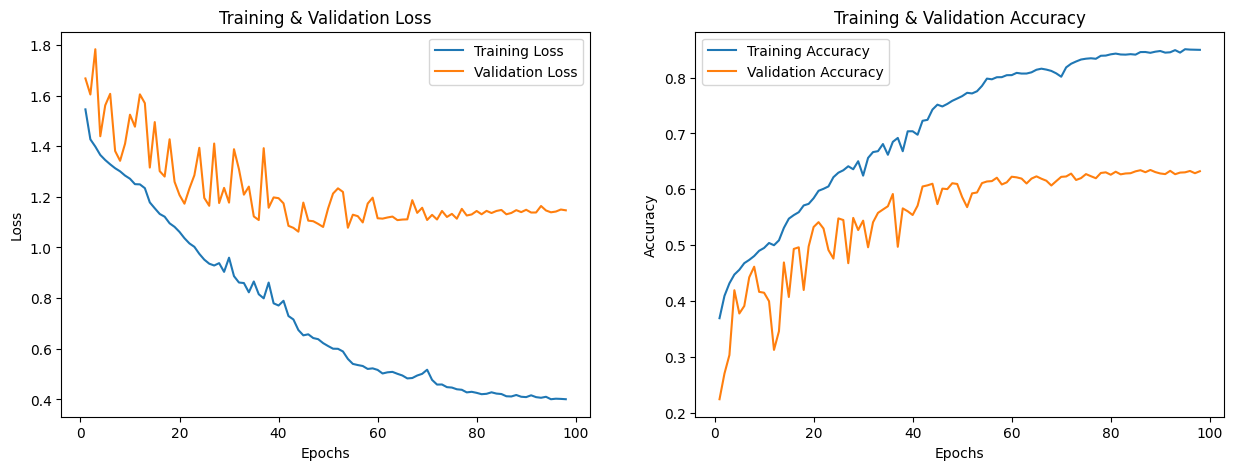


Final Model Evaluation on Test Data:
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6373 - loss: 1.1545
Test Accuracy: 63.46%
Test Loss: 1.1474
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.83      0.81      0.82       749
     disgust       0.57      0.53      0.55       765
        fear       0.60      0.59      0.60       793
       happy       0.78      0.62      0.69       780
     neutral       0.54      0.60      0.57       643
         sad       0.53      0.66      0.59       736

    accuracy                           0.63      4466
   macro avg       0.64      0.63      0.64      4466
weighted avg       0.64      0.63      0.64      4466


Confusion Matrix:


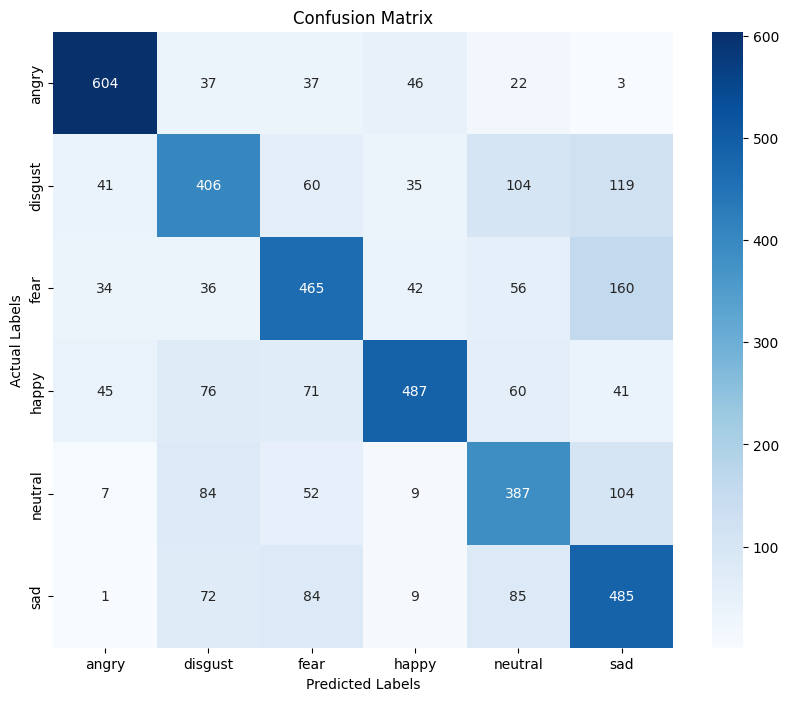

In [18]:
# ==============================================================================
# STEP 10: EVALUATE THE MODEL
# ==============================================================================
print("\nStep 10: Evaluating the model performance...")

# Plot training history
epochs = range(1, len(history.history['accuracy']) + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(epochs, history.history['loss'], label='Training Loss')
ax[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

# Final evaluation on test data
print("\nFinal Model Evaluation on Test Data:")
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Predictions and Confusion Matrix
y_pred = model.predict(x_test)
y_pred_labels = encoder.inverse_transform(y_pred)
y_test_labels = encoder.inverse_transform(y_test)

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [19]:
# STEP 11: SAVE MODEL, SCALER, AND ENCODER
# ==============================================================================
print("\nStep 11: Saving model architecture, weights, and preprocessing objects...")

# Save model architecture to JSON
model_json = model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_json)

# The best weights were already saved by the ModelCheckpoint callback as 'best_cnn_model.h5'
print("Model architecture saved to cnn_model.json")
print("Best model weights saved to best_cnn_model.h5")

# Save the scaler and encoder using pickle
with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)
with open('encoder.pickle', 'wb') as f:
    pickle.dump(encoder, f)

print("Scaler saved to scaler.pickle")
print("Encoder saved to encoder.pickle")


Step 11: Saving model architecture, weights, and preprocessing objects...
Model architecture saved to cnn_model.json
Best model weights saved to best_cnn_model.h5
Scaler saved to scaler.pickle
Encoder saved to encoder.pickle


In [20]:

# ==============================================================================
# STEP 12: CREATE A PREDICTION SCRIPT FOR NEW AUDIO
# ==============================================================================
print("\nStep 12: Example prediction script for a new audio file.")
print("You can use this block to test single audio files in the future.")

# Define the prediction function
def predict_emotion(audio_path):
    # --- Load all necessary files ---
    # Load model architecture
    with open('cnn_model.json', 'r') as json_file:
        loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)

    # Load model weights
    loaded_model.load_weights("best_cnn_model.h5")

    # Load scaler and encoder
    with open('scaler.pickle', 'rb') as f:
        scaler = pickle.load(f)
    with open('encoder.pickle', 'rb') as f:
        encoder = pickle.load(f)

    # --- Feature Extraction for a single file ---
    data, sr = librosa.load(audio_path, duration=2.5, offset=0.6)
    features = extract_features(data, sr)
    features = np.array(features).reshape(1, -1) # Reshape for scaler

    # --- Scaling and Reshaping for model ---
    scaled_features = scaler.transform(features)
    final_features = np.expand_dims(scaled_features, axis=2)

    # --- Prediction ---
    prediction = loaded_model.predict(final_features)
    predicted_label = encoder.inverse_transform(prediction)

    return predicted_label[0][0]

# --- USAGE EXAMPLE ---
# Find a random file from your dataset to test the prediction script
try:
    test_file_path = data_path.Path.sample(1).iloc[0]
    predicted_emotion = predict_emotion(test_file_path)

    print(f"\n--- Prediction Test ---")
    print(f"File Path: {test_file_path}")
    print(f"Predicted Emotion: {predicted_emotion.upper()}")

except Exception as e:
    print(f"\nCould not run prediction example. Error: {e}")
    print("Make sure your dataset path is correct and files are accessible.")

print("\n\n===== SCRIPT FINISHED =====")


Step 12: Example prediction script for a new audio file.
You can use this block to test single audio files in the future.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step

--- Prediction Test ---
File Path: /content/drive/MyDrive/AudioWAV/1013_TIE_FEA_XX.wav
Predicted Emotion: FEAR


===== SCRIPT FINISHED =====


In [21]:
pip install tensorflow sounddevice librosa scikit-learn

In [ ]:
# ==============================================================================
# AI EMOTION COMPANION - CONTINUOUS PREDICTION AND RESPONSE
# ==============================================================================
from IPython.display import HTML, Audio, display
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import pickle
import random
from tensorflow.keras.models import model_from_json
import librosa
import io
import os

# --- CONFIGURATION ---
MODEL_JSON_PATH = "cnn_model.json"
MODEL_WEIGHTS_PATH = "best_cnn_model.h5"
SCALER_PATH = "scaler.pickle"
ENCODER_PATH = "encoder.pickle"
RECORDING_FILENAME = "audio.wav"

# --- JAVASCRIPT FOR BROWSER-BASED AUDIO RECORDING (ROBUST VERSION) ---
AUDIO_HTML = """
<script>
var record = () => new Promise(async resolve => {
  const div = document.createElement('div');
  const startButton = document.createElement('button');
  startButton.textContent = 'Start Recording';
  div.appendChild(startButton);

  const stopButton = document.createElement('button');
  stopButton.textContent = 'Stop Recording';
  stopButton.disabled = true;
  div.appendChild(stopButton);

  const audio = document.createElement('audio');
  audio.controls = true;
  div.appendChild(audio);

  document.body.appendChild(div);

  let recorder, stream;

  startButton.onclick = async () => {
    stream = await navigator.mediaDevices.getUserMedia({audio: true});
    recorder = new MediaRecorder(stream);
    let chunks = [];
    recorder.ondataavailable = e => chunks.push(e.data);

    recorder.onstop = e => {
      const blob = new Blob(chunks, { 'type' : 'audio/ogg; codecs=opus' });
      const audioURL = window.URL.createObjectURL(blob);
      audio.src = audioURL;
      const reader = new FileReader();
      reader.readAsDataURL(blob);
      reader.onloadend = () => resolve(reader.result);
    };

    recorder.start();
    startButton.disabled = true;
    stopButton.disabled = false;
    startButton.textContent = 'Recording...';
  };

  stopButton.onclick = () => {
    recorder.stop();
    stream.getTracks().forEach(track => track.stop());
    startButton.disabled = false;
    stopButton.disabled = true;
    startButton.textContent = 'Start New Recording';
  };
});
</script>
"""

def get_audio():
  """Displays the HTML/JS for recording and returns the recorded audio file."""
  display(HTML(AUDIO_HTML))
  data = eval_js("record()")
  if ',' not in data:
      return None
  binary = b64decode(data.split(',')[1])
  with open(RECORDING_FILENAME, 'wb') as f:
    f.write(binary)
  return RECORDING_FILENAME

# --- FEATURE EXTRACTION FUNCTION ---
def extract_features(data, sr=22050):
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc))
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mel))
    return result

# --- LOAD MODEL AND PREPROCESSORS ---
try:
    with open(MODEL_JSON_PATH, 'r') as json_file:
        loaded_model_json = json_file.read()
    model = model_from_json(loaded_model_json)
    model.load_weights(MODEL_WEIGHTS_PATH)
    with open(SCALER_PATH, 'rb') as f:
        scaler = pickle.load(f)
    with open(ENCODER_PATH, 'rb') as f:
        encoder = pickle.load(f)
    print("AI Emotion Companion is ready!")
except Exception as e:
    print(f"Error loading model files: {e}")
    model = None

# --- DEFINE COMPANION RESPONSES ---
sad_quotes = [
    "\"The way I see it, if you want the rainbow, you gotta put up with the rain.\" - Dolly Parton",
    "\"It's okay not to be okay. Tough times don't last, but tough people do.\"",
    "\"Every day may not be good, but there is something good in every day.\"",
    "\"Believe you can and you're halfway there.\" - Theodore Roosevelt"
]

response_map = {
    'happy': "That's wonderful! Your voice sounds full of joy. Keep that positive energy going!",
    'sad': sad_quotes, # This is a special case handled below
    'angry': "Your voice has a strong, intense energy. Remember to take a deep breath; it can make a world of difference.",
    'fear': "I detected a sense of fear in your voice. Whatever you're facing, remember you are stronger than you think.",
    'disgust': "That's a strong reaction! Your voice suggests you're not a fan of something.",
    'neutral': "Your tone is calm and neutral. What's on your mind today?"
}

# --- MAIN PREDICTION LOOP ---
def run_emotion_companion():
    if not model:
        return

    print("\nThis session will run continuously. To stop, click the square 'Stop' button in the Colab cell menu.")

    try:
        while True:
            print("\n----------------------------------------------------")
            print("Please record your voice using the buttons below:")

            audio_file = get_audio()

            if not audio_file:
                print("Recording failed. Please try again.")
                continue

            # Process the audio and make a prediction
            data, sr = librosa.load(audio_file, sr=22050)
            features = extract_features(data)
            features_reshaped = features.reshape(1, -1)
            scaled_features = scaler.transform(features_reshaped)
            final_features = np.expand_dims(scaled_features, axis=2)

            prediction = model.predict(final_features, verbose=0)
            predicted_label = encoder.inverse_transform(prediction)[0][0]

            print(f"\n>>> PREDICTED EMOTION: {predicted_label.upper()} <<<")

            # Get and display the companion's response
            if predicted_label.lower() == 'sad':
                response = random.choice(response_map['sad'])
            else:
                response = response_map.get(predicted_label.lower(), "I'm listening. Tell me more.")

            print(f"\nAI Companion: {response}\n")

    except KeyboardInterrupt:
        print("\n\nEmotion companion session ended. Have a great day!")

# Start the companion
run_emotion_companion()

AI Emotion Companion is ready!

This session will run continuously. To stop, click the square 'Stop' button in the Colab cell menu.

----------------------------------------------------
Please record your voice using the buttons below:


/tmp/ipython-input-25-2009617763.py:151: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(audio_file, sr=22050)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



>>> PREDICTED EMOTION: FEAR <<<

AI Companion: I detected a sense of fear in your voice. Whatever you're facing, remember you are stronger than you think.


----------------------------------------------------
Please record your voice using the buttons below:


/tmp/ipython-input-25-2009617763.py:151: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(audio_file, sr=22050)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



>>> PREDICTED EMOTION: HAPPY <<<

AI Companion: That's wonderful! Your voice sounds full of joy. Keep that positive energy going!


----------------------------------------------------
Please record your voice using the buttons below:


/tmp/ipython-input-25-2009617763.py:151: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(audio_file, sr=22050)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



>>> PREDICTED EMOTION: FEAR <<<

AI Companion: I detected a sense of fear in your voice. Whatever you're facing, remember you are stronger than you think.


----------------------------------------------------
Please record your voice using the buttons below:


/tmp/ipython-input-25-2009617763.py:151: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(audio_file, sr=22050)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



>>> PREDICTED EMOTION: FEAR <<<

AI Companion: I detected a sense of fear in your voice. Whatever you're facing, remember you are stronger than you think.


----------------------------------------------------
Please record your voice using the buttons below:


/tmp/ipython-input-25-2009617763.py:151: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(audio_file, sr=22050)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



>>> PREDICTED EMOTION: HAPPY <<<

AI Companion: That's wonderful! Your voice sounds full of joy. Keep that positive energy going!


----------------------------------------------------
Please record your voice using the buttons below:
